# Part 3. Classification of Sentinel-1  Time Series

__SAR data are not especially good for vegetation classification. However they have the great advantage of being independent of cloud cover. Here we investigate the use of S1 time series over a complete growth period for thematic mapping.__

__Since we have no ground truth data, we will use the Canada AAFC Annual Crop Inventory, which is also on the GEE archive. In particular the 2017 inventory for an area in southern Saskatchewan.__

__Large agricultural fields__

__Well-defined crops__

__Flat terrain (a big advantage for SAR measurement)__

In [1]:
%matplotlib inline
import ee
from ipyleaflet import Map, GeoJSON, TileLayer
ee.Initialize()

In [ ]:
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

m = Map(center=(50.0, -90.0), zoom=4)


dataset = ee.ImageCollection('AAFC/ACI')
crop2016 = dataset \
    .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
    .first()
m.add_layer(TileLayer(url=GetTileLayerUrl(crop2016)))

m

__Multilook SAR image data are not normally distributed, rather they are gamma distributed. The GEE classifiers might be expected not to work so well.__ 

__So we will use Tensorflow to program a more flexible neural network classifier.__

In [16]:
from auxil.eeSar_seq import run
run()

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

__Get a time series for the region of interest:__

In [23]:
%matplotlib inline
import ee
ee.Initialize()
poly = {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-104.887301, 49.98722699999997], [-104.293845, 49.98722699999997], [-104.293845, 50.248838751582234], [-104.887301, 50.248838751582234], [-104.887301, 49.98722699999997]]]}
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                      .filterBounds(poly) \
                      .filterDate(ee.Date('2017-04-01'), ee.Date('2017-11-01')) \
                      .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV','VH'])) \
                      .filter(ee.Filter.eq('resolution_meters', 10)) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.eq('relativeOrbitNumber_start',5)) \
                      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))  
collection.size().getInfo()

16

__Strip off the incidence angle band and convert from DB to linear scale:__

In [24]:
import math
def get_vvvh(image):   
    ''' get 'VV' and 'VH' bands from sentinel-1 imageCollection and restore linear signal from db-values '''
    return image.select('VV','VH').multiply(ee.Image.constant(math.log(10.0)/10.0)).exp()

In [25]:
from auxil.eeRL import refinedLee
timeseries = collection \
            .map(get_vvvh) \       # get VV, VH bands and linearize      
            .map(refinedLee) \     # apply refined Lee speckle filter
            .toBands() \           # collapse to a single image
            .clip(poly) \          # clip to the ROI
            .float()               # make floating point

__Add the class labels as the last band:__ 

In [26]:
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
    .first() \
    .clip(timeseries.geometry())\
    .float()
labeled_timeseries = ee.Image.cat(timeseries,crop2017)

__Export to drive for downloading:__

In [27]:
drexport = ee.batch.Export.image.toDrive(labeled_timeseries,
                  description='driveExportTask', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries',scale=30,maxPixels=1e9)
drexport.start()
print('Exporting labeled timeseries to %s\n task id: %s'%('EarthEngineImages/labeled_timeseries',str(drexport.id)))

Exporting labeled timeseries to EarthEngineImages/labeled_timeseries
 task id: None


__Export to GEE assets for reference:__

In [28]:
assetId = 'users/mortcanty/zfl2020/labeled_timeseries'
assexport = ee.batch.Export.image.toAsset(labeled_timeseries,
                  description='assetExportTask', 
                  assetId=assetId,scale=10,maxPixels=1e9)
assexport.start()
print('Exporting labeled timeseries to %s\n task id: %s'%(assetId,str(assexport.id)))

Exporting labeled timeseries to users/mortcanty/zfl2020/labeled_timeseries
 task id: 3LUA6RXJUVGXEV23HITWFOQA


In [32]:
!ls imagery/

AAFC.txt		labels.tif		     T20180927_28_atsf.tif
dtsf_image.tif		radarsat2bonn		     T20180927_28_gamma.tif
dtsf_log_image.tif	southyorkshire		     T20180927_28.tif
euskirchen		T12_atsf_pauli.tif	     T20181126_38_atsf_enl.tif
ffa			T12_atsf.tif		     T20181126_38_atsf.tif
hambach			T12_pauli.tif		     T20200204_26_atsf.tif
kangaroo_island		T12.tif
labeled_timeseries.tif	T20180927_28_atsf_gamma.tif


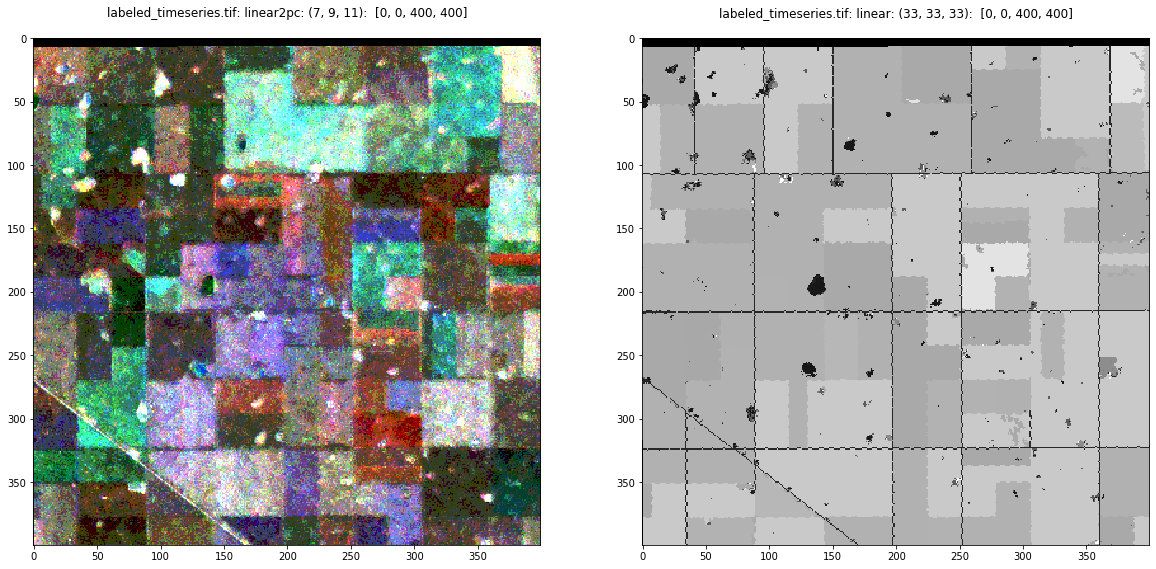

In [38]:
%run scripts/dispms -f imagery/labeled_timeseries.tif -p [7,9,11] -e 3 -d [0,0,400,400] \
-F imagery/labeled_timeseries.tif -P [33,33,33] -E 2 -D [0,0,400,400]

__Read the labeled time series into a Numpy array, which we will use to train a Tensorflow NN classifier:__

In [39]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Byte
import numpy as np

gdal.AllRegister()                   
inDataset = gdal.Open('imagery/labeled_timeseries.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_timeseries = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
driver = inDataset.GetDriver() # for later    
inDataset = None
labeled_timeseries = np.nan_to_num(labeled_timeseries)

print(labeled_timeseries.shape)
m = labeled_timeseries.shape[0]
print(m)

(1389738, 33)
1389738


In [40]:
classnums = np.unique(labeled_timeseries[:,-1])
print(classnums)

[  0.  20.  30.  34.  50.  80. 110. 122. 131. 133. 136. 137. 145. 146.
 153. 154. 155. 158. 162. 174. 193. 196. 210. 220.]


In [41]:
classdict = {'0':'Nc'}
filepath = 'imagery/AAFC.txt'
with open(filepath) as fp:
    line = fp.readline()
    key = line[:3].replace('\t','')
    value = line[10:].replace('\t',' ').replace('\n','')
    classdict.update({key:value})
    while line:
        line = fp.readline()
        key = line[:3].replace('\t','')
        value = line[10:].replace('\t','').replace('\n','')
        classdict.update({key:value})
del classdict['']

In [42]:
classnames = str([classdict[str(int(cn))] for cn in classnums])
classnames

"['Nc', 'Water', 'Exposed Land and Barren', 'Urban and Developed', 'Shrubland', 'Wetland', 'Grassland', 'Pasture and Forages', 'Fallow', 'Barley', 'Oats', 'Rye', 'Winter Wheat', 'Spring Wheat', 'Canola and Rapeseed', 'Flaxseed', 'Mustard', 'Soybeans', 'Peas', 'Lentils', 'Herbs', 'Canaryseed', 'Coniferous', 'Broadleaf']"

__Renumber the labels consecutively from 0:__

In [43]:
i=0
labels = labeled_timeseries[:,-1]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8) 
print(np.unique(labels))
n_classes = len(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


__Write labels as an image image to disk for comparison:__

In [44]:
outDataset = driver.Create('imagery/labels.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None

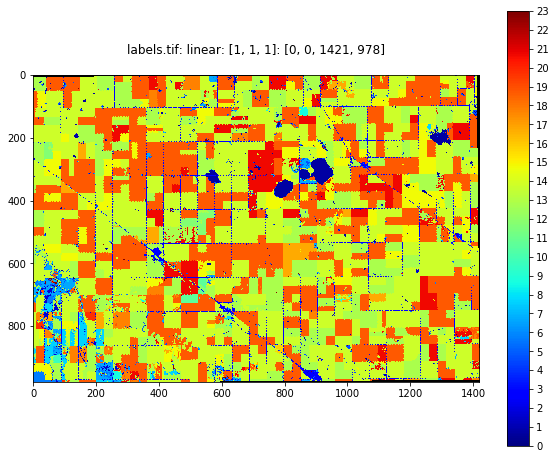

In [45]:
%run scripts/dispms -f imagery/labels.tif -c 

__Now we simulate ground truth by taking a random subset of training pixels:__

In [46]:
# random subset for training
n = 200000
idx = np.random.permutation(m)[0:n]
# training vectors normalized -1 to 1 
Xs = labeled_timeseries[idx,:-1]*100

# one hot encoded class labels
Ls = np.array(labels[idx],dtype=np.int)
print(Ls[0:5])
ls = np.zeros((n,n_classes))
for i in range(n):
    ls[i,Ls[i]] = 1
print(ls[0:5,:])

[15 21 14 14 19]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


### Neural network classification using tensorflow

In [47]:
%%time
import auxil.dnn as dnn

classifier = dnn.Dnn([40,40],n_classes,learning_rate=0.002)
classifier.train(Xs,ls,epochs=100)

CPU times: user 16min 42s, sys: 56.6 s, total: 17min 39s
Wall time: 11min 46s


True

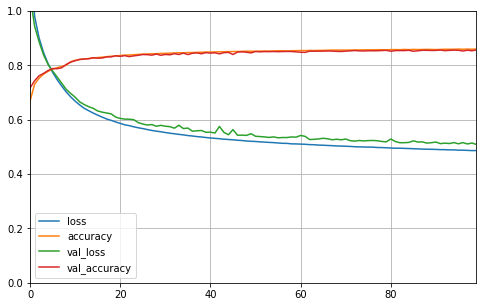

In [48]:
classifier.history()

__Classify (predict) the entire image:__

In [49]:
cls,Ms = classifier.classify(labeled_timeseries[:,0:-1]*100) 
cls[0]=1
cls[1]=n_classes-1
print(Ms.shape)

(1389738, 24)


__Save the trained classifier:__

In [50]:
classifier.save('classifier1.h5')

__Write the thematic map and the class probabilities images to disk:__

In [51]:
# write the class image to disk
outDataset = driver.Create('imagery/timeseries_class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None
# write the class probabilities to disk
bands = Ms.shape[1]
Ms = np.byte(Ms*255)
outDataset = driver.Create('imagery/timeseries_probs.tif',cols,rows,bands,GDT_Byte)
for b in range(bands):
    outBand = outDataset.GetRasterBand(b+1)
    outBand.WriteArray(np.reshape(Ms[:,b],(rows,cols)))
    outBand.FlushCache()
outDataset = None

__Test the classifier with all of the training data:__

In [52]:
classifier.test(Xs,ls)

0.140435

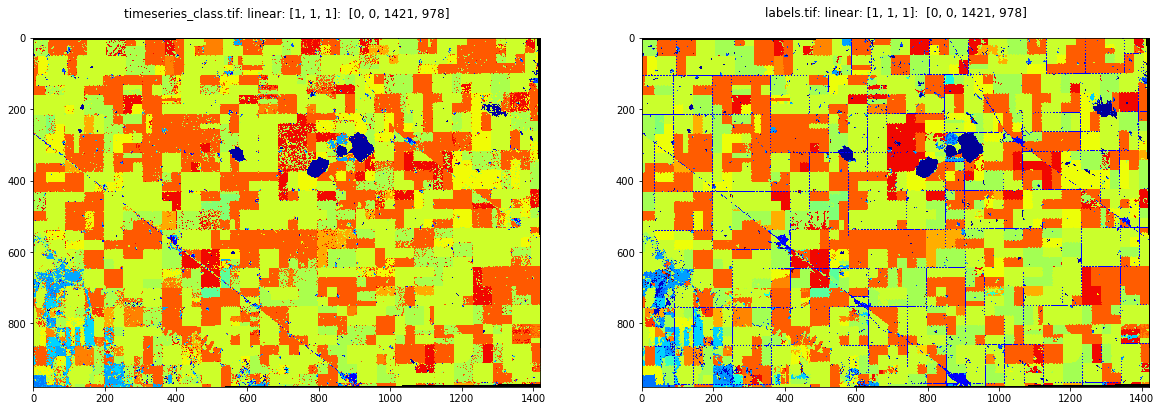

<Figure size 432x288 with 0 Axes>

In [53]:
%run scripts/dispms -f imagery/timeseries_class.tif -c -F imagery/labels.tif -C

### Probabilistic Label Relaxation

In [54]:
%run scripts/plr -i 3 imagery/timeseries_probs.tif

       PLR
infile:  imagery/timeseries_probs.tif
iterations:  3
estimating compatibility matrix...
label relaxation...
iteration 1
iteration 2
iteration 3
result written to: imagery/timeseries_probs_plr.tif
elapsed time: 103.69044756889343
--done------------------------


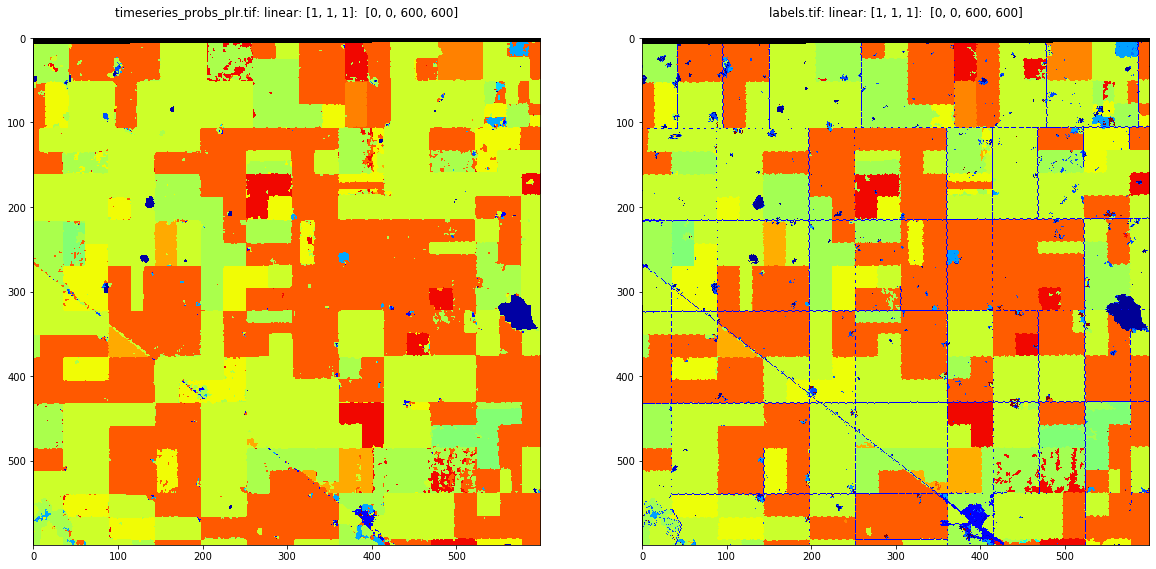

In [56]:
%run scripts/dispms -f imagery/timeseries_probs_plr.tif -c -d [0,0,600,600] \
                    -F imagery/labels.tif -C -D [0,0,600,600]